In [1]:
import numpy as np
import pandas as pd
import spacy
import nltk
import re
import os
import torch
from transformers import AutoConfig, AutoTokenizer, AutoModelForMaskedLM
from transformers.pipelines import FillMaskPipeline
from tqdm import tqdm

#### Set up the Model Options

In [2]:
model_name_or_path = "roberta-large"
max_len = 512
k = 4
path = "./../data/wikipedia/ogUTF-8/1208667-ORIG-4.txt"
nlp = spacy.load("en_core_web_sm", disable=["parser"])
with open(path, 'r', encoding='utf-8') as file:
    toy_sentence = file.read()

#### Load the Model

In [3]:
config = AutoConfig.from_pretrained(model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, model_max_length=max_len)
masked_model = AutoModelForMaskedLM.from_pretrained(model_name_or_path, config=config)

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at roberta-large and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Create the Pipeline

In [4]:
masked_pipe = FillMaskPipeline(model=masked_model, tokenizer=tokenizer)

In [5]:
def check_token(token: str) -> bool:
    return bool(re.fullmatch(r"[A-Za-z]+([-'][A-Za-z]+)*", token))

In [6]:
def insert_mask(i: int, t_len: int, text: str, mask_token: str) -> str:
    return text[:i] + mask_token + text[i+t_len:]

### Set up the example text

In [7]:
doc = nlp(toy_sentence)
print(toy_sentence)

Statton was born in Beaconsfield, Tasmania, on 21 October 1890 to Edward Statton, a miner, and his wife Maggie Lavinia (née Hoskins). He was educated at Zeehan State School, before gaining employment as a farmer in Tyenna. Giving his age as twenty-one, Statton married Elsie May Pearce in a Methodist ceremony on 12 September 1907; the couple later had a son and two daughters.


In [8]:
indices = np.array([i for i in range(len(doc))])
for ent in doc.ents:
    indices[ent.start:ent.end] = -1
indices = np.array([i for i in indices if i >= 0 and check_token(doc[i].text)])
indices

array([ 1,  2,  3,  8, 12, 16, 17, 19, 20, 21, 26, 29, 30, 31, 32, 37, 38,
       39, 40, 41, 42, 43, 46, 47, 48, 49, 50, 52, 55, 58, 59, 60, 62, 63,
       71, 72, 73, 74, 76])

### Test for the first Token that can be replaced

In [83]:
t_idx = indices[0]

#### for the Pipeline

In [87]:
pipe_in = insert_mask(doc[t_idx].idx, len(doc[t_idx]), toy_sentence, tokenizer.mask_token)
pipe_out = masked_pipe(pipe_in, top_k=k)
pipe_token = np.array([t['token'] for t in pipe_out])
pipe_socre = np.array([t['score'] for t in pipe_out])

In [88]:
pipe_token

array([  21, 7325,   16,   58])

In [175]:
[tokenizer.convert_ids_to_tokens(int(t)) for t in pipe_token]

['Ġwas', 'was', 'Ġis', 'Ġwere']

In [89]:
pipe_socre

array([9.99974489e-01, 1.05791069e-05, 4.63241895e-06, 2.47411299e-06])

#### for the normal Model

How much of the token shuld be replaced in addition

In [164]:
p = 0.3
N = max(int(len([1 for t in doc if check_token(t.text)]) * p) - 1, 0)
mask_idc = np.random.choice([i for i in indices if i != t_idx], N, replace=False)
mask_idc = np.sort(np.append(mask_idc, t_idx))
t_pos = np.searchsorted(mask_idc, t_idx)
mask_idc

array([ 1, 16, 19, 20, 29, 30, 38, 46, 47, 49, 50, 52, 58, 59, 63, 71, 73,
       76])

In [165]:
model_in = toy_sentence
for i in mask_idc[::-1]:
    model_in = insert_mask(doc[i].idx, len(doc[i]), model_in, tokenizer.mask_token)
model_in

'Statton <mask> born in Beaconsfield, Tasmania, on 21 October 1890 to Edward Statton, <mask> miner, <mask> <mask> wife Maggie Lavinia (née Hoskins). <mask> <mask> educated at Zeehan State School, before <mask> employment as a farmer in Tyenna. <mask> <mask> age <mask> <mask>-<mask>, Statton married Elsie May <mask> <mask> a Methodist ceremony <mask> 12 September 1907; the couple later <mask> a <mask> and two <mask>.'

In [166]:
inputs = tokenizer(
    model_in,
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors='pt'
)
preds = masked_model(**inputs)
activated_preds = torch.softmax(preds[0], dim=2)
masked_token_indices = (inputs['input_ids'] == tokenizer.mask_token_id)
masked_preds = activated_preds[masked_token_indices]
topk = torch.topk(masked_preds, k, dim=1)
model_token = topk.indices[t_pos].numpy()
model_score = topk.values[t_pos].detach().numpy()

In [167]:
model_token

array([  21,   16, 7325,   58])

In [174]:
[tokenizer.convert_ids_to_tokens(int(t)) for t in model_token]

['Ġwas', 'Ġis', 'was', 'Ġwere']

### compare the "Models" for one text

In [32]:
p = 0.1
N = max(int(len([1 for t in doc if check_token(t.text)]) * p) - 1, 0)

In [36]:
df = None
store_mask_idc = dict()

for t_idx in tqdm(indices):
    # for the mask pipeline
    pipe_in = insert_mask(doc[t_idx].idx, len(doc[t_idx]), toy_sentence, tokenizer.mask_token)
    pipe_out = masked_pipe(pipe_in, top_k=k)
    pipe_token = np.array([t['token'] for t in pipe_out])
    pipe_socre = np.array([t['score'] for t in pipe_out])

    # for the normal model
    # dertement which token should be replaced in addtion
    mask_idc = np.random.choice([i for i in indices if i != t_idx], N, replace=False)
    mask_idc = np.sort(np.append(mask_idc, t_idx))
    t_pos = np.searchsorted(mask_idc, t_idx)
    # insert the mask tokens
    model_in = toy_sentence
    for i in mask_idc[::-1]:
        model_in = insert_mask(doc[i].idx, len(doc[i]), model_in, tokenizer.mask_token)
    # run the mask model
    inputs = tokenizer(
        model_in,
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors='pt'
    )
    preds = masked_model(**inputs)
    activated_preds = torch.softmax(preds[0], dim=2)
    masked_token_indices = (inputs['input_ids'] == tokenizer.mask_token_id)
    masked_preds = activated_preds[masked_token_indices]
    topk = torch.topk(masked_preds, k, dim=1)
    model_token = topk.indices[t_pos].numpy()
    model_score = topk.values[t_pos].detach().numpy()

    # store the results in a DataFrame
    df_indices = [[], [], [], []]
    df_data = {'new_pipe': [] ,'score_pipe': [], 'new_model': [], 'score_modle': []}

    new_pipe = [tokenizer.convert_ids_to_tokens(int(t)) for t in pipe_token]
    new_model = [tokenizer.convert_ids_to_tokens(int(t)) for t in model_token]

    df_indices[0].extend(4*[t_idx])
    df_indices[1].extend(4*[doc[t_idx].text])
    df_indices[2].extend(4*[nltk.edit_distance(new_pipe, new_model, substitution_cost=2, transpositions=True)])
    df_indices[3].extend([i+1 for i in range(4)])
    df_data['new_pipe'].extend(new_pipe)
    df_data['score_pipe'].extend(pipe_socre)
    df_data['new_model'].extend(new_model)
    df_data['score_modle'].extend(model_score)

    df_MultiIndex = pd.MultiIndex.from_arrays(df_indices, names=['t_idx', 'og_token', 'edit_dist', 'pos'])
    if type(df) is pd.DataFrame:
       df = df.append(pd.DataFrame(df_data, index= df_MultiIndex))
    else:
        df = pd.DataFrame(df_data, index= df_MultiIndex)
    # store the mask indices for the normal model
    store_mask_idc[t_idx] = mask_idc

100%|██████████| 39/39 [00:32<00:00,  1.20it/s]


In [56]:
toy_sentence

'Statton was born in Beaconsfield, Tasmania, on 21 October 1890 to Edward Statton, a miner, and his wife Maggie Lavinia (née Hoskins). He was educated at Zeehan State School, before gaining employment as a farmer in Tyenna. Giving his age as twenty-one, Statton married Elsie May Pearce in a Methodist ceremony on 12 September 1907; the couple later had a son and two daughters.'

In [37]:
df.query('pos == 1 & new_pipe != new_model')

,,,,new_pipe,score_pipe,new_model,score_modle
t_idx,og_token,edit_dist,pos,,,,
46,Giving,8,1,ĠGiving,0.595367,ĠAt,0.965172
58,Pearce,3,1,nard,0.040820,field,0.030288
62,ceremony,4,1,Ġchurch,0.527530,ĠChurch,0.768625


In [38]:
store_mask_idc[58]

array([19, 29, 38, 58, 62, 74])

In [39]:
df.query('pos == 2 & new_pipe != new_model')

,,,,new_pipe,score_pipe,new_model,score_modle
t_idx,og_token,edit_dist,pos,,,,
46,Giving,8,2,ĠReporting,0.311990,ĠOn,0.008358
58,Pearce,3,2,field,0.039326,nard,0.020772
62,ceremony,4,2,Ġceremony,0.175827,Ġchurch,0.189142
63,on,2,2,Ġdated,0.000574,Ġin,0.000528


In [40]:
df.query('t_idx == 2')

new_pipe    score_pipe  new_model  score_modle
t_idx og_token edit_dist pos                                                 
2     born     0         1        Ġborn  9.999921e-01      Ġborn     0.999989
                         2        ĠBorn  2.734768e-06      ĠBorn     0.000004
                         3         born  2.513455e-06       born     0.000003
                         4    Ġbaptized  8.927365e-07  Ġbaptized     0.000001

In [49]:
df.query('edit_dist == 8')

new_pipe  score_pipe new_model  score_modle
t_idx og_token edit_dist pos                                                
46    Giving   8         1        ĠGiving    0.595367       ĠAt     0.965172
                         2     ĠReporting    0.311990       ĠOn     0.008358
                         3     ĠRecording    0.029245  ĠDespite     0.008125
                         4    ĠAccounting    0.013219       ĠBy     0.006876

<AxesSubplot:>

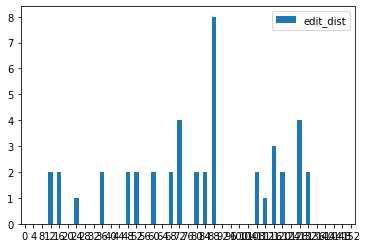

In [78]:
df.index.to_frame(index=False).query('pos == 1').plot.bar(y='edit_dist', rot=0)

## compare the "Models" for sample texts

Idea determen avg edit distance over sample texts for different p

In [25]:
amount = [0.05 ,0.1, 0.15, 0.2]
M = 10# diferent texts

#### choose some sample texts

In [26]:
path = "./../data/wikipedia/ogUTF-8"
files = np.random.choice([os.path.join(path ,f) for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))], M, replace=False)

for f_path in files:
    with open(f_path, 'r', encoding='utf-8') as file:
        text = file.read()
    tokens = tokenizer(
        text,
        max_length=tokenizer.model_max_length,
        truncation=True,
    )
    if len(tokens['input_ids']) == 512:
        print('One paragraph might be to long!!!')
        break
print('Every paragraph fits into the modle')

Every paragraph fits into the modle


#### run the models

In [27]:
count_edit_distances = dict()
for p in amount:
    count_edit_distances[p] = (2*k+1)*[0]
for f_path in files:
    with open(f_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # tokenize the text
    doc = nlp(text)
    # determent all tokens that can be replaced
    indices = np.array([i for i in range(len(doc))])
    for ent in doc.ents:
        indices[ent.start:ent.end] = -1
    indices = np.array([i for i in indices if i >= 0 and check_token(doc[i].text)])

    for t_idx in tqdm(indices):
        # for the mask pipeline
        pipe_in = insert_mask(doc[t_idx].idx, len(doc[t_idx]), text, tokenizer.mask_token)
        pipe_out = masked_pipe(pipe_in, top_k=k)
        pipe_token = np.array([t['token'] for t in pipe_out])
        new_pipe = [tokenizer.convert_ids_to_tokens(int(t)) for t in pipe_token]

        for j, p in enumerate(amount):
            # for the normal model
            # dertement which token should be replaced in addtion
            N = max(int(len([1 for t in doc if check_token(t.text)]) * p) - 1, 0)
            mask_idc = np.random.choice([i for i in indices if i != t_idx], N, replace=False)
            mask_idc = np.sort(np.append(mask_idc, t_idx))
            t_pos = np.searchsorted(mask_idc, t_idx)
            # insert the mask tokens
            model_in = text
            for i in mask_idc[::-1]:
                model_in = insert_mask(doc[i].idx, len(doc[i]), model_in, tokenizer.mask_token)
            # run the mask model
            inputs = tokenizer(
                model_in,
                max_length=tokenizer.model_max_length,
                truncation=True,
                return_tensors='pt'
            )
            preds = masked_model(**inputs)
            activated_preds = torch.softmax(preds[0], dim=2)
            masked_token_indices = (inputs['input_ids'] == tokenizer.mask_token_id)
            masked_preds = activated_preds[masked_token_indices]
            topk = torch.topk(masked_preds, k, dim=1)
            model_token = topk.indices[t_pos].numpy()
            new_model = [tokenizer.convert_ids_to_tokens(int(t)) for t in model_token]

            # incres the counter for the edit distance
            count_edit_distances[p][nltk.edit_distance(new_pipe, new_model, substitution_cost=2, transpositions=True)] += 1

# store the edit distances in a DataFrame
df_edit_dist = pd.DataFrame(count_edit_distances)

100%|██████████| 100/100 [07:10<00:00,  4.30s/it]


In [28]:
df_edit_dist

,0.05,0.10,0.15,0.20
0,618,451,340,255
1,182,171,147,131
2,308,357,336,353
3,63,78,103,102
4,84,156,211,248
5,8,13,15,23
6,29,49,106,133
7,0,0,0,0
8,6,23,40,53


<AxesSubplot:>

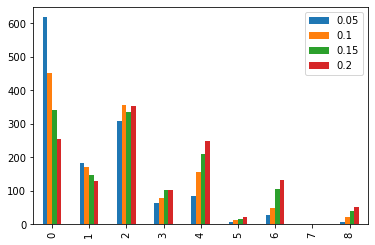

In [29]:
df_edit_dist.plot.bar()

In [24]:
df_edit_dist

,0.1,0.2,0.3
0,45,26,20
1,12,11,9
2,33,32,31
3,4,4,6
4,6,15,19
5,0,1,0
6,3,9,15
7,0,0,0
8,0,5,3


<AxesSubplot:>

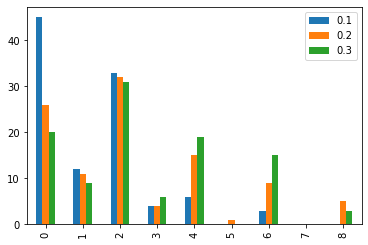

In [23]:
df_edit_dist.plot.bar()

### limit the replacements for one model calls

In [ ]:
toy_sentence
doc
indices

In [165]:
# amount of tokens to replace
p = 1
# maximal amount of tokens that can be replaced at once
max_p = 0.1
# 100% of the tokens (tokens that sitisfie the regular expression)
len_tokens = len([1 for t in doc if check_token(t.text)])
print(f'len_tokens: {len_tokens}')
# the number of tokens to replace is grater than zero and smaler than the number of thokens that can be replaced
N = min(max(int(len_tokens * p), 0), len(indices))
print(f'N: {N}')

max_N = int(len_tokens * max_p)
print(f'max_N: {max_N}')

# steps = N // max_N + (0 if N % max_N == 0 else 1)
# print(f'steps: {steps}')

len_tokens: 60
N: 39
max_N: 6


In [166]:
rng = np.random.default_rng()
mask_idc = rng.choice(indices, size=(max(N//max_N, 1),min(max_N, N)), replace=False)
if N > max_N and N % max_N != 0:
    rest_idc = np.setdiff1d(indices, mask_idc)
    if N < len(indices):
        rest_idc = rng.choice(rest_idc, size=N%max_N, replace=False)
    mask_idc = np.append(mask_idc, np.append(rest_idc, (max_N-N%max_N)*[-1]).reshape(1,-1), axis=0)
mask_idc = np.sort(mask_idc)
mask_idc

array([[ 8, 26, 37, 39, 73, 76],
       [ 2, 20, 40, 49, 50, 60],
       [19, 38, 43, 48, 59, 74],
       [16, 17, 30, 47, 55, 71],
       [ 1, 21, 31, 41, 58, 62],
       [12, 29, 32, 42, 46, 72],
       [-1, -1, -1,  3, 52, 63]])

In [180]:
for idc in mask_idc:
    model_in = toy_sentence
    for i in idc[::-1]:
        if i >= 0:
            model_in = insert_mask(doc[i].idx, len(doc[i]), model_in, tokenizer.mask_token)

    inputs = tokenizer(
        model_in,
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors='pt'
    )
    preds = masked_model(**inputs)
    activated_preds = torch.softmax(preds[0], dim=2)
    masked_token_indices = (inputs['input_ids'] == tokenizer.mask_token_id)
    masked_preds = activated_preds[masked_token_indices]
    topk = torch.topk(masked_preds, k, dim=1)
    
    model_token = topk.indices.numpy()
    new_model = []
    for pos in model_token:
        new_model.append([tokenizer.convert_ids_to_tokens(int(t)) for t in pos])
    
    print('------------------')
    new_model = np.array(new_model)
    print(new_model)

------------------
[['Ġon' 'Ġin' 'on' 'Ġdated']
 ['ĠSmith' 'ĠWilliams' 'ĠBrown' 'ĠWilson']
 ['Ġbefore' 'Ġlater' 'Ġafter' 'Ġsubsequently']
 ['Ġemployment' 'Ġwork' 'Ġexperience' 'Ġland']
 ['Ġson' 'Ġdaughter' 'Ġchild' 'Ġboy']
 ['Ġdaughters' 'Ġsons' 'Ġchildren' 'Ġgirls']]
------------------
[['Ġborn' 'ĠBorn' 'born' 'Ġbaptized']
 ['Ġhis' 'Ġfirst' 'Ġsecond' 'Ġthird']
 ['Ġas' 'Ġwith' 'Ġfor' 'Ġat']
 ['Ġas' 'Ġof' 'Ġat' 'Ġwas']
 ['Ġtwenty' 'Ġthirty' 'Ġforty' 'Ġfifty']
 ['Ġa' 'Ġan' 'Ġthe' 'Ġtheir']]
------------------
[['Ġand' 'and' 'Ġwith' 'Ġ&']
 ['Ġfinding' 'Ġgaining' 'Ġtaking' 'Ġseeking']
 ['Ġin' 'Ġat' 'Ġnear' 'Ġon']
 ['Ġage' 'Ġbirthday' 'Ġages' 'Ġyears']
 ['Ġin' 'Ġat' 'Ġduring' 'Ġwith']
 ['Ġand' ',' 'Ġwith' 'Ġplus']]
------------------
[['Ġa' 'Ġan' 'Ġlabou' 'Ġcoal']
 ['Ġfarmer' 'Ġbutcher' 'Ġgrocer' 'Ġminer']
 ['Ġwas' 'Ġbecame' 'Ġis' 'was']
 ['Ġhis' 'Ġher' 'Ġtheir' 'Ġthe']
 ['Ġmarried' 'Ġwed' 'ĠMarried' 'Ġmet']
 ['Ġhad' 'Ġadopted' 'Ġproduced' 'Ġraised']]
------------------
[['Ġwas' 'was' 'Ġis'

### to long paragraphs

In [17]:
number_files = 200
path = "./../data/wikipedia/ogUTF-8"
files = np.random.choice([os.path.join(path ,f) for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))], number_files, replace=False)

for f_path in files:
    with open(f_path, 'r', encoding='utf-8') as file:
        text = file.read()
    tokens = tokenizer(
        text,
        max_length=tokenizer.model_max_length,
        truncation=True,
    )
    if len(tokens['input_ids']) == 512:
        print(f_path)
        print('One paragraph might be to long!!!')
        break
# print('Every paragraph fits into the modle')

./../data/wikipedia/ogUTF-8/2423186-ORIG-11.txt
One paragraph might be to long!!!


In [9]:
# 39871658-ORIG-10.txt
# 2423186-ORIG-11.txt
with open('./../data/wikipedia/ogUTF-8/39871658-ORIG-10.txt', 'r', encoding='utf-8') as file:
    text = file.read()

In [38]:
for _ in tqdm(range(10000)):
    tokens = tokenizer(
        text,
        max_length=tokenizer.model_max_length,
        truncation=True,
    )
    decode_text = tokenizer.decode(tokens['input_ids'])[3:-4]

100%|██████████| 10000/10000 [00:16<00:00, 599.66it/s]


In [39]:
for _ in tqdm(range(10000)):
    tokens = tokenizer(
        text,
        max_length=tokenizer.model_max_length,
        truncation=True,
    )
    # decode_text = tokenizer.decode(tokens['input_ids'])[3:-4]

100%|██████████| 10000/10000 [00:11<00:00, 852.07it/s]


In [40]:
for _ in tqdm(range(10000)):
    # tokens = tokenizer(
    #     text,
    #     max_length=tokenizer.model_max_length,
    #     truncation=True,
    # )
    decode_text = tokenizer.decode(tokens['input_ids'])[3:-4]

100%|██████████| 10000/10000 [00:04<00:00, 2172.86it/s]


In [10]:
nlp_sentencizer = spacy.load("en_core_web_sm", disable=["parser", "tagger", "ner"])
nlp_sentencizer.add_pipe(spacy.lang.en.English().create_pipe("sentencizer"))

sents = list(nlp_sentencizer(text).sents)

In [11]:
sents

[On February 3, 2013, IWGP Junior Heavyweight Champion Prince Devitt pinned IWGP Heavyweight Champion Hiroshi Tanahashi in a tag team match, where he and Karl Anderson faced Tanahashi and Devitt's longtime Apollo 55 tag team partner Ryusuke Taguchi.,
 This led to a match between Devitt and Tanahashi on March 3 at NJPW's 41st anniversary event.,
 Though neither man's title was on the line in the match, Tanahashi vowed to relinquish the IWGP Heavyweight Championship in case Devitt was victorious.,
 After defeating Devitt, Tanahashi went to help his opponent up, but was pushed away by the disappointed Junior Heavyweight Champion.,
 The following weeks, Devitt began portraying a more cocky and villainous persona, regularly disrespecting both partners and opponents, with the exception of Ryusuke Taguchi, whom he tried to get to go along with his new attitude.,
 However, this changed on April 7 at the Invasion Attack pay-per-view, when Devitt turned on Taguchi, after the two had failed to re

In [13]:
work_text = text
parparaphs = []
while work_text != '':
    tokens = tokenizer(
        work_text,
        max_length=512,
        truncation=True,
        return_tensors='pt'
    )
    text_docode = tokenizer.decode(tokens['input_ids'][0])[3:-4]

    if text_docode == work_text:
        parpgraphs.append(work_text)
        work_text = ''
    else:
        tmp_doc = nlp_sentencizer(text_docode)
        tmp_sents = list(tmp_doc.sents)
        parparaphs.append(work_text[:tmp_sents[-1].start_char])
        work_text = work_text[tmp_sents[-1].start_char:]

for para in parparaphs:
    print('------------------')
    print(para)

------------------
On February 3, 2013, IWGP Junior Heavyweight Champion Prince Devitt pinned IWGP Heavyweight Champion Hiroshi Tanahashi in a tag team match, where he and Karl Anderson faced Tanahashi and Devitt's longtime Apollo 55 tag team partner Ryusuke Taguchi. This led to a match between Devitt and Tanahashi on March 3 at NJPW's 41st anniversary event. Though neither man's title was on the line in the match, Tanahashi vowed to relinquish the IWGP Heavyweight Championship in case Devitt was victorious. After defeating Devitt, Tanahashi went to help his opponent up, but was pushed away by the disappointed Junior Heavyweight Champion. The following weeks, Devitt began portraying a more cocky and villainous persona, regularly disrespecting both partners and opponents, with the exception of Ryusuke Taguchi, whom he tried to get to go along with his new attitude. However, this changed on April 7 at the Invasion Attack pay-per-view, when Devitt turned on Taguchi, after the two had fail

### One word to one mask VS One word to mask for each sub token

In [9]:
def tokenization_mapping(model_tok : list, doc) -> list:
    # getting the indices of all named entities
    ne_list = []
    for ent in doc.ents:
        ne_list.extend([i for i in range(ent.start, ent.end)])

    mapping = []
    j = 0# doc index
    start = 0# start index for next token in model_tok
    token = ''
    for i, t in enumerate(model_tok):
        t = t.replace(' ', '')# remove leading spaces from t

        # while next doc token can be ingnorred (is name entity or has wrong form)
        while j in ne_list or not check_token(doc[j].text):
            j += 1
            if j >= len(doc):
                return mapping

        # if t is next part of doc[j].text
        if doc[j].text.startswith(t, len(token), len(token)+len(t)):
            # if t is the first part of doc[j].text (then len(token)=0 => token='')
            if token == '':
                start = i
                token = t
            else:
                token += t
        else:
            # if not set token againg to the empty string
            token = ''

        # if all parts of doc[j].text were found
        if token == doc[j].text:
            mapping.append([j, start, i+1])
            j += 1
            if j >= len(doc):
                break
            token = ''

    return mapping

#### Find texts with many words that get dividet into sub word tokens

In [26]:
number_files = 200
path = "./../data/wikipedia/ogUTF-8"
files = np.random.choice([os.path.join(path ,f) for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))], number_files, replace=False)

number_relevant_tokens = []
relevant_paths = []
for f_path in files:
    with open(f_path, 'r', encoding='utf-8') as file:
        text = file.read()
    tokens = tokenizer(
        text,
        max_length=tokenizer.model_max_length,
        truncation=True,
    )
    model_tok = [tokenizer.decode(t) for t in tokens['input_ids']]

    doc = nlp(text)

    mapping = tokenization_mapping(model_tok, doc)

    count = 0
    for _, a, b in mapping:
        count += 1 if b - a > 1 else 0
    number_relevant_tokens.append(count)
    relevant_paths.append(f_path)

relevant_I = np.argmax(number_relevant_tokens)
print(number_relevant_tokens[relevant_I])
print(relevant_paths[relevant_I])

33
./../data/wikipedia/ogUTF-8/365342-ORIG-5.txt


In [27]:
argsort = np.argsort(number_relevant_tokens)[::-1]
for i in argsort[:5]:
    print(number_relevant_tokens[i])
    print(relevant_paths[i])

33
./../data/wikipedia/ogUTF-8/365342-ORIG-5.txt
32
./../data/wikipedia/ogUTF-8/34568634-ORIG-7.txt
23
./../data/wikipedia/ogUTF-8/26611936-ORIG-30.txt
23
./../data/wikipedia/ogUTF-8/8171787-ORIG-9.txt
22
./../data/wikipedia/ogUTF-8/28543061-ORIG-8.txt


#### some investigation on the texts

In [57]:
file_path = './../data/wikipedia/ogUTF-8/365342-ORIG-5.txt'
# file_path = './../data/wikipedia/ogUTF-8/34568634-ORIG-7.txt'
# file_path = './../data/wikipedia/ogUTF-8/26611936-ORIG-30.txt'
# file_path = './../data/wikipedia/ogUTF-8/8171787-ORIG-9.txt'
# file_path = './../data/wikipedia/ogUTF-8/28543061-ORIG-8.txt'

with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()
text

'Red-tailed hawk plumage can be variable, depending on the subspecies and the region. These color variations are morphs, and are not related to molting. The western North American population, "B. j. calurus", is the most variable subspecies and has three main color morphs: light, dark, and intermediate or rufous. The dark and intermediate morphs constitute 10–20% of the population in the western United States but seem to constitute only 1–2% of "B. j. calurus" in western Canada. A whitish underbelly with a dark brown band across the belly, formed by horizontal streaks in feather patterning, is present in most color variations. This feature is variable in eastern hawks and generally absent in some light subspecies (i.e. "B. j. fuertesi"). Most adult red-tails have a dark brown nape and upper head which gives them a somewhat hooded appearance, while the throat can variably present a lighter brown “necklace”. Especially in younger birds, the underside may be otherwise covered with dark br

In [58]:
tokens = tokenizer(
    text,
    max_length=tokenizer.model_max_length,
    truncation=True,
)
model_tok = [tokenizer.decode(t) for t in tokens['input_ids']]

doc = nlp(text)

mapping = tokenization_mapping(model_tok, doc)

for i, a, b in mapping:
    if b - a > 1:
        print(f'{doc[i]} -> {model_tok[a:b]}')

plumage -> [' plum', 'age']
subspecies -> [' sub', 'species']
morphs -> [' morph', 's']
molting -> [' mol', 'ting']
subspecies -> [' sub', 'species']
morphs -> [' morph', 's']
rufous -> [' r', 'uf', 'ous']
morphs -> [' morph', 's']
whitish -> [' whit', 'ish']
underbelly -> [' under', 'b', 'elly']
patterning -> [' pattern', 'ing']
subspecies -> [' sub', 'species']
fuertesi -> [' fu', 'ert', 'esi']
nape -> [' n', 'ape']
hooded -> [' hood', 'ed']
variably -> [' vari', 'ably']
necklace -> ['neck', 'lace']
stippling -> [' st', 'ipp', 'ling']
paler -> [' pal', 'er']
scapular -> [' sc', 'ap', 'ular']
tawny -> [' t', 'awn', 'y']
rufous -> [' r', 'uf', 'ous']
variably -> [' vari', 'ably']
subterminal -> [' sub', 'termin', 'al']
immatures -> [' imm', 'atures']
paler -> [' pal', 'er']
morphs -> [' morph', 's']
subspecies -> [' sub', 'species']
hawks -> [' haw', 'ks']
hues -> [' h', 'ues']
rufous -> [' r', 'uf', 'ous']
tinge -> [' t', 'inge']
raptors -> [' rapt', 'ors']


#### compare the different approches

In [59]:
reduced_mapping = []
for m in mapping:
    if m[2] - m[1] > 1:
        reduced_mapping.append(m)
len(reduced_mapping)

33

with sub tokens

In [63]:
for mask_idx in range(len(reduced_mapping)):
    inputs = tokenizer(
        text,
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors='pt'
    )

    a = reduced_mapping[mask_idx][1]
    b = reduced_mapping[mask_idx][2]
    for i in range(a, b):
        inputs['input_ids'][0,i] = tokenizer.mask_token_id

    preds = masked_model(**inputs)
    activated_preds = torch.softmax(preds[0], dim=2)
    masked_token_indices = (inputs['input_ids'] == tokenizer.mask_token_id)
    masked_preds = activated_preds[masked_token_indices]
    topk = torch.topk(masked_preds, k, dim=1)

    model_token = topk.indices.numpy()
    sub_token_suggestions = []
    for pos in model_token:
        sub_token_suggestions.append([tokenizer.convert_ids_to_tokens(int(t)) for t in pos])

    print(f'og_tokens: {model_tok[a:b]} \n   {sub_token_suggestions}')

og_tokens: [' plum', 'age'] 
   [['Ġplum', 'Ġcarc', 'Ġcamoufl', 'Ġlum'], ['age', 'aging', 'ge', 'aged']]
og_tokens: [' sub', 'species'] 
   [['Ġsub', 'Ġunsub', 'Ġsuper', 'ĠSub'], ['species', 'population', 'specific', 'series']]
og_tokens: [' morph', 's'] 
   [['Ġmorph', 'Ġglyph', 'Ġpolymorph', 'ĠMorph'], ['s', 'ing', 'Ġs', 'S']]
og_tokens: [' mol', 'ting'] 
   [['Ġmol', 'Ġbol', 'Ġmal', 'Ġmat'], ['ting', 'ts', 'ted', 'TING']]
og_tokens: [' sub', 'species'] 
   [['Ġsub', 'Ġunsub', 'ĠSub', 'Ġsuper'], ['species', 'population', 'series', 'Ġspecies']]
og_tokens: [' morph', 's'] 
   [['Ġmorph', 'Ġglyph', 'ĠMorph', 'Ġpolymorph'], ['s', 'Ġs', 'S', 'ings']]
og_tokens: [' r', 'uf', 'ous'] 
   [['Ġr', 'ĠR', 'r', 'Ġl'], ['uf', 'uss', 'auc', 'uff'], ['ous', 'us', 'ously', 'OUS']]
og_tokens: [' morph', 's'] 
   [['Ġmorph', 'Ġglyph', 'ĠMorph', 'Ġreg'], ['s', 'Ġs', 'ings', 'S']]
og_tokens: [' whit', 'ish'] 
   [['Ġwhit', 'Ġwhite', 'Ġwhites', 'Ġwh'], ['ish', 'ishing', 'ished', 'ening']]
og_tokens: [' un

In [61]:
text

'Red-tailed hawk plumage can be variable, depending on the subspecies and the region. These color variations are morphs, and are not related to molting. The western North American population, "B. j. calurus", is the most variable subspecies and has three main color morphs: light, dark, and intermediate or rufous. The dark and intermediate morphs constitute 10–20% of the population in the western United States but seem to constitute only 1–2% of "B. j. calurus" in western Canada. A whitish underbelly with a dark brown band across the belly, formed by horizontal streaks in feather patterning, is present in most color variations. This feature is variable in eastern hawks and generally absent in some light subspecies (i.e. "B. j. fuertesi"). Most adult red-tails have a dark brown nape and upper head which gives them a somewhat hooded appearance, while the throat can variably present a lighter brown “necklace”. Especially in younger birds, the underside may be otherwise covered with dark br

only one mask per word

In [62]:
for mask_idx in range(len(reduced_mapping)):
    model_in = text
    doc_i = reduced_mapping[mask_idx][0]
    model_in = insert_mask(doc[doc_i].idx, len(doc[doc_i]), model_in, tokenizer.mask_token)

    inputs = tokenizer(
        model_in,
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors='pt'
    )
    preds = masked_model(**inputs)
    activated_preds = torch.softmax(preds[0], dim=2)
    masked_token_indices = (inputs['input_ids'] == tokenizer.mask_token_id)
    masked_preds = activated_preds[masked_token_indices]
    topk = torch.topk(masked_preds, k, dim=1)

    model_token = topk.indices.numpy()
    full_word_suggestions = []
    for pos in model_token:
        full_word_suggestions.append([tokenizer.convert_ids_to_tokens(int(t)) for t in pos])

    print(f'og_token: {doc[doc_i].text} \n   {full_word_suggestions}')

og_token: plumage 
   [['Ġcolor', 'Ġcolors', 'Ġcoloring', 'Ġappearance']]
og_token: subspecies 
   [['Ġspecies', 'Ġbird', 'Ġindividual', 'Ġbreed']]
og_token: morphs 
   [['Ġnatural', 'Ġseasonal', 'Ġpermanent', 'Ġrandom']]
og_token: molting 
   [['Ġsex', 'Ġindividuals', 'Ġsize', 'Ġspecies']]
og_token: subspecies 
   [[',', 'Ġspecies', 'Ġone', 'Ġgroup']]
og_token: morphs 
   [['Ġvariations', 'Ġgroups', 'Ġtypes', 'Ġforms']]
og_token: rufous 
   [['Ġintermediate', 'Ġmixed', 'Ġgray', 'Ġvariable']]
og_token: morphs 
   [['Ġforms', 'Ġmorph', 'Ġcolors', 'Ġtypes']]
og_token: whitish 
   [['Ġwhite', 'Ġpale', 'Ġlighter', 'Ġlight']]
og_token: underbelly 
   [['Ġbelly', 'Ġunderside', 'Ġabdomen', 'Ġbody']]
og_token: patterning 
   [['Ġrows', 'Ġbeds', 'Ġpatterns', 'Ġtips']]
og_token: subspecies 
   [['Ġforms', 'Ġvarieties', 'Ġspecies', 'Ġtypes']]
og_token: fuertesi 
   [['Ġminor', 'Ġdispar', 'Ġray', 'Ġmajor']]
og_token: nape 
   [['Ġneck', 'Ġthroat', 'Ġchest', 'Ġback']]
og_token: hooded 
   [['Ġrough